In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from bg_utils import *
from bg_dataset import *

import os
import sys
%matplotlib inline

In [2]:
mb_size = 100 # mini_batchsize
dim_input = 200 # 输入数据的维度

dra_tra_pro = False

D_dim = [dim_input, 100, 50, 2] # discriminator 每一层神经元个数
G_dim = [50, 100, dim_input] # generator 每一层神经元个数
Z_dim = G_dim[0]  # 输入噪声的维度

In [3]:
# 定义 labeled-data、unlabeled-data、noise-data and target-data 的占位符
X_oc = tf.placeholder(tf.float32, shape=[None, dim_input]) # real benign data
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])  # noise
X_tar = tf.placeholder(tf.float32, shape=[None, dim_input]) # target data (complementary data)

# 定义discriminator的Weights和biases
D_W1 = tf.Variable(xavier_init([D_dim[0], D_dim[1]])) # shape=(200,100)
D_b1 = tf.Variable(tf.zeros(shape=[D_dim[1]])) # shape=(100,)

D_W2 = tf.Variable(xavier_init([D_dim[1], D_dim[2]]))
D_b2 = tf.Variable(tf.zeros(shape=[D_dim[2]]))

D_W3 = tf.Variable(xavier_init([D_dim[2], D_dim[3]]))
D_b3 = tf.Variable(tf.zeros(shape=[D_dim[3]]))

theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]  # cache

# 定义generator的weights和biases
G_W1 = tf.Variable(xavier_init([G_dim[0], G_dim[1]]))
G_b1 = tf.Variable(tf.zeros(shape=[G_dim[1]]))

G_W2 = tf.Variable(xavier_init([G_dim[1], G_dim[2]]))
G_b2 = tf.Variable(tf.zeros(shape=[G_dim[2]]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

# 定义pre-train net for density estimation的weights和biases
T_W1 = tf.Variable(xavier_init([D_dim[0], D_dim[1]]))
T_b1 = tf.Variable(tf.zeros(shape=[D_dim[1]]))

T_W2 = tf.Variable(xavier_init([D_dim[1], D_dim[2]]))
T_b2 = tf.Variable(tf.zeros(shape=[D_dim[2]]))

T_W3 = tf.Variable(xavier_init([D_dim[2], D_dim[3]]))
T_b3 = tf.Variable(tf.zeros(shape=[D_dim[3]]))

theta_T = [T_W1, T_W2, T_W3, T_b1, T_b2, T_b3]

In [4]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_logit = tf.nn.tanh(tf.matmul(G_h1, G_W2) + G_b2)
    return G_logit

def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
    D_logit = tf.matmul(D_h2, D_W3) + D_b3
    D_prob = tf.nn.softmax(D_logit)
    return D_prob, D_logit, D_h2

# pre-train net for density estimation  
# 对 P_data()  的分布进行估计，以便计算P_data(G(z)) > threshold
def discriminator_tar(x):
    T_h1 = tf.nn.relu(tf.matmul(x, T_W1) + T_b1)
    T_h2 = tf.nn.relu(tf.matmul(T_h1, T_W2) + T_b2)
    T_logit = tf.matmul(T_h2, T_W3) + T_b3
    T_prob = tf.nn.softmax(T_logit)
    return T_prob, T_logit, T_h2

In [5]:
D_prob_real, D_logit_real, D_h2_real = discriminator(X_oc) # real data经过判别器的计算中间值

G_sample = generator(Z)
D_prob_gen, D_logit_gen, D_h2_gen = discriminator(G_sample) # 由noise生成fake data，再经过判别器

D_prob_tar, D_logit_tar, D_h2_tar = discriminator_tar(X_tar) # target data 经过判别器_tar
D_prob_tar_gen, D_logit_tar_gen, D_h2_tar_gen = discriminator_tar(G_sample) # 由noise生成fake data，经过判别器_tar


### loss function of discriminator :

In [6]:
# loss of discriminator
y_real = tf.placeholder(tf.int32, shape=[None, D_dim[3]])  # real data对应的labels
y_gen = tf.placeholder(tf.int32, shape=[None, D_dim[3]])  # fake data对应的labels

D_loss_real = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=D_logit_real,labels=y_real))
D_loss_gen = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=D_logit_gen, labels=y_gen))

ent_real_loss = -tf.reduce_mean(tf.reduce_sum(tf.multiply(D_prob_real, tf.log(D_prob_real)), 1))

ent_gen_loss = -tf.reduce_mean(tf.reduce_sum(tf.multiply(D_prob_gen, tf.log(D_prob_gen)), 1))

D_loss = D_loss_real + D_loss_gen + 1.85*ent_real_loss

### loss function of generator :

In [7]:
# loss of generator
pt_loss = pull_away_loss(D_h2_tar_gen) # PT_term，最小化这一项近似最小化 -H(P_G)

y_tar = tf.placeholder(tf.int32, shape=[None, D_dim[3]])
T_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=D_logit_tar, labels=y_tar))

# ε is a threshold to indicate whether the generated samples are in high-density regions
tar_thrld = tf.divide(tf.reduce_max(D_prob_tar_gen[:,-1]) + tf.reduce_min(D_prob_tar_gen[:,-1]), 2)

indicator = tf.sign(tf.subtract(D_prob_tar_gen[:,-1], tar_thrld))  # 判断 P_data(G(z)) > threshold
condition = tf.greater(tf.zeros_like(indicator), indicator)  # 示性函数的完整定义
mask_tar = tf.where(condition, tf.zeros_like(indicator), indicator) # 满足示性函数条件则有计算值，否则为同shape的0
G_ent_loss = tf.reduce_mean(tf.multiply(tf.log(D_prob_tar_gen[:,-1]), mask_tar))

fm_loss = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(D_logit_real - D_logit_gen), 1)))

G_loss = pt_loss + G_ent_loss + fm_loss

In [8]:
D_solver = tf.train.GradientDescentOptimizer(learning_rate=1e-3).minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)
T_solver = tf.train.GradientDescentOptimizer(learning_rate=1e-3).minimize(T_loss, var_list=theta_T)

In [9]:
# load data
min_max_scaler = MinMaxScaler()

x_benign = min_max_scaler.fit_transform(np.load('data/wiki/ben_hid_emd_4_50_8_200_r0.npy'))  # (10528, 200)
x_vandal = min_max_scaler.transform(np.load('data/wiki/val_hid_emd_4_50_8_200_r0.npy')) # (11495, 200)

x_benign = sample_shuffle_uspv(x_benign)
x_vandal = sample_shuffle_uspv(x_vandal)

x_benign = x_benign[:10000]
x_vandal = x_vandal[:10000]
x_pre = x_benign[:7000]

y_pre = np.zeros(len(x_pre)) # (7000, ) 全为0
y_pre = one_hot(y_pre, 2) # (7000, 2) array([ [1, 0], [1, 0], ...,[1, 0]], dtype=int32)

x_train = x_pre # 训练集是benign这类

y_real_mb = one_hot(np.zeros(mb_size), 2)  # (mb_size, 2) array([[1, 0], [1, 0], ...,[1, 0]], dtype=int32)
y_fake_mb = one_hot(np.ones(mb_size), 2) # (100, 2) array([[0, 1], [0, 1], ...,[0, 1]], dtype=int32)

x_test = x_benign[-3000:].tolist() + x_vandal[-3000:].tolist()
x_test = np.array(x_test)

y_test = np.zeros(len(x_test))
y_test[3000:] = 1 # benign -- 0    vandal -- 1

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# pre-training for P_data() distribution
_ = sess.run(T_solver, feed_dict={X_tar:x_pre, y_tar:y_pre}) # 用benign数据先训练discriminator_T

q = int(len(x_train) / mb_size)

d_ben_pro, d_fake_pro, fm_loss_coll = list(), list(), list()
f1_score = list()
d_val_pro = list()

n_round = 50

for n_epoch in range(n_round):
    X_mb_oc = sample_shuffle_uspv(x_train)
    for n_batch in range(q):
        # fix G，train D
        _, D_loss_curr, ent_real_curr = sess.run([D_solver, D_loss, ent_real_loss],
                                                 feed_dict={
                                                     X_oc: X_mb_oc[n_batch*mb_size:(n_batch+1)*mb_size], # benign data
                                                     Z: sample_Z(mb_size, Z_dim), # noise
                                                     y_real: y_real_mb, # labels of benign data
                                                     y_gen: y_fake_mb # labels of fake data
                                                 })
        # fix D，train G
        _, G_loss_curr, fm_loss_curr = sess.run([G_solver, G_loss, fm_loss], 
                                                feed_dict={
                                                    Z: sample_Z(mb_size, Z_dim),
                                                    X_oc: X_mb_oc[n_batch*mb_size:(n_batch+1)*mb_size], # 计算G_loss中的项fm_loss
                                                })
    # 一轮训练结束，计算一下 D 对训练集的预测概率、对生成数据的预测概率、对实际的vandal数据的预测概率
    # 用于绘曲线，检查 D 的分类效果
    D_prob_real_, D_prob_gen_ = sess.run([D_prob_real, D_prob_gen],
                                         feed_dict={
                                             X_oc: x_train,
                                             Z: sample_Z(len(x_train), Z_dim)
                                         })
    D_prob_vandal_ = sess.run(D_prob_real, feed_dict={X_oc: x_vandal[0:7000]})
    
    d_ben_pro.append(np.mean(D_prob_real_[:, 0]))
    d_fake_pro.append(np.mean(D_prob_gen_[:, 0]))
    d_val_pro.append(np.mean(D_prob_vandal_[:, 0]))
    fm_loss_coll.append(fm_loss_curr)
    
    # test 模型 D 的分类效果
    prob, _ = sess.run([D_prob_real, D_logit_real], feed_dict={X_oc: x_test})
    y_pred = np.argmax(prob, axis=1)
    conf_mat = classification_report(y_test, y_pred, target_names=['benign', 'vandal'], digits=4)
    f1_score.append(float(list(filter(None, conf_mat.strip().split(" ")))[12]))

/Users/chaojunwang/anaconda2/envs/python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

     benign     0.9238    0.9010    0.9123      3000
     vandal     0.9034    0.9257    0.9144      3000

avg / total     0.9136    0.9133    0.9133      6000

acc:0.9133333333333333


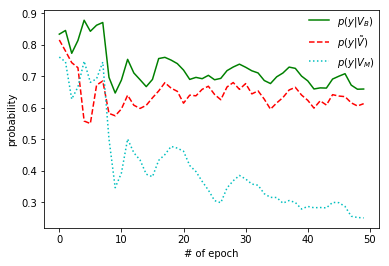

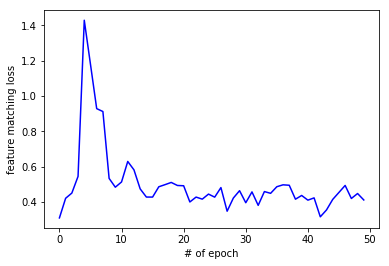

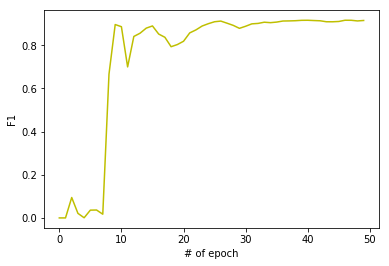

In [15]:
if not dra_tra_pro:
    acc = np.sum(y_pred == y_test)/float(len(y_pred))
    print(conf_mat)
    print("acc:%s"%acc)

if not dra_tra_pro:
    draw_trend(d_ben_pro, d_fake_pro, d_val_pro, fm_loss_coll, f1_score)